# Personalized Climate Indices

## Imports

In [1]:
import xarray as xr
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from metpy.calc import advection
from metpy.units import units


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [4]:
from IndexDrivers import (
    Index,
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

## Code

### Preprocess Extra Indices

Let's preprocess the extra indices for ML. We use here DMI (Dipole Mode Index), ONI (Oceanic Niño Index), PDO (Pacific Decadal Oscillation), ENSO3.4 and 1+2 and SAM.

In [5]:
df_oni = pd.read_csv("data/extra_indices/oni.txt",sep="   |  | ", header=None, engine="python", names=["Season", "Year", "sst", "ONI"])
df_pdo = pd.read_csv("data/extra_indices/pdo.dat",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_sam = pd.read_csv("data/extra_indices/sam.txt",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
# df_meiv2 = pd.read_csv("data/extra_indices/meiv2.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso34 = pd.read_csv("data/extra_indices/nino34.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso12 = pd.read_csv("data/extra_indices/nino12.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_dmi = pd.read_csv("data/extra_indices/dmi.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])

In [6]:
def preprocess_df(df, name):
    df = df.melt(id_vars=['Year'], var_name='Month', value_name=name)
    df["Month"] = pd.to_numeric(df["Month"])
    df = df.sort_values(['Year','Month'])

    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
    df.set_index("Date", inplace=True)
    df.drop(columns=["Year", "Month"],inplace=True)
    return df

In [7]:
df_oni = pd.read_csv("data/extra_indices/oni.txt",sep="   |  | ", header=None, engine="python", names=["Season", "Year", "sst", "ONI"])
df_pdo = pd.read_csv("data/extra_indices/pdo.dat",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_sam = pd.read_csv("data/extra_indices/sam.txt",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
# df_meiv2 = pd.read_csv("data/extra_indices/meiv2.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso34 = pd.read_csv("data/extra_indices/nino34.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso12 = pd.read_csv("data/extra_indices/nino12.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_dmi = pd.read_csv("data/extra_indices/dmi.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])

season_to_month = {
    "DJF": "02", "JFM": "03", "FMA": "04", "MAM": "05",
    "AMJ": "06", "MJJ": "07", "JJA": "08", "JAS": "09",
    "ASO": "10", "SON": "11", "OND": "12", "NDJ": "01"
}
df_oni["Year"] = df_oni.apply(lambda row: row["Year"] + 1 if row["Season"] == "NDJ" else row["Year"], axis=1)
df_oni["month"] = df_oni["Season"].map(season_to_month)
df_oni["Date"] = pd.to_datetime(df_oni["Year"].astype(str) + "-" + df_oni["month"])

# Select required columns
df_oni = df_oni[["Date", "ONI"]]
df_oni.set_index("Date", inplace=True)

df_pdo = preprocess_df(df_pdo, "PDO")
df_sam = preprocess_df(df_sam, "SAM")
# df_meiv2 = preprocess_df(df_meiv2, "MEI")
df_enso34 = preprocess_df(df_enso34, "ENSO34")
df_enso12 = preprocess_df(df_enso12, "ENSO12")
df_dmi = preprocess_df(df_dmi, "DMI")

In [8]:
df_pdo = df_pdo[(df_pdo.index.year >= 1972) & (df_pdo.index.year <=2022)]
df_oni = df_oni[(df_oni.index.year >= 1972) & (df_oni.index.year <=2022)]
df_sam = df_sam[(df_sam.index.year >= 1972) & (df_sam.index.year <=2022)]
# df_meiv2 = df_meiv2[(df_meiv2.index.year >= 1972) & (df_meiv2.index.year <=2022)]
df_enso34 = df_enso34[(df_enso34.index.year >= 1972) & (df_enso34.index.year <=2022)]
df_enso12 = df_enso12[(df_enso12.index.year >= 1972) & (df_enso12.index.year <=2022)]
df_dmi = df_dmi[(df_dmi.index.year >= 1972) & (df_dmi.index.year <=2022)]



### Definition of Predictors

In [ ]:
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_mslp = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")
ref_period = [1980,2010]
target_period = [1972, 2022]

In [66]:
vec = data_single.isel(longitude=0, latitude=0).ttr
df = vec.to_dataframe()
df[df["ttr"]>=1e7]

,longitude,latitude,ttr
time,,,
1971-01-31,180.0,-60.0,19627536.0
1971-02-28,180.0,-60.0,19140720.0
1971-03-31,180.0,-60.0,18788560.0
1971-04-30,180.0,-60.0,18439744.0
1971-05-31,180.0,-60.0,17753136.0
...,...,...,...
1977-08-31,180.0,-60.0,16752064.0
1977-09-30,180.0,-60.0,17877568.0
1977-10-31,180.0,-60.0,18115648.0


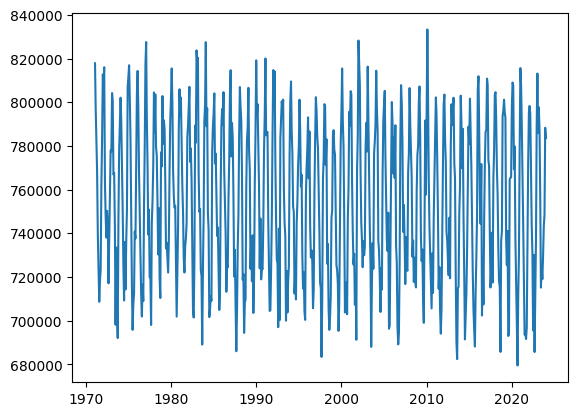

In [68]:
vec = data_single.isel(longitude=0, latitude=0).ttr
vec[:84] = vec[:84]/24
plt.plot(data_single.time, vec)

### Advection

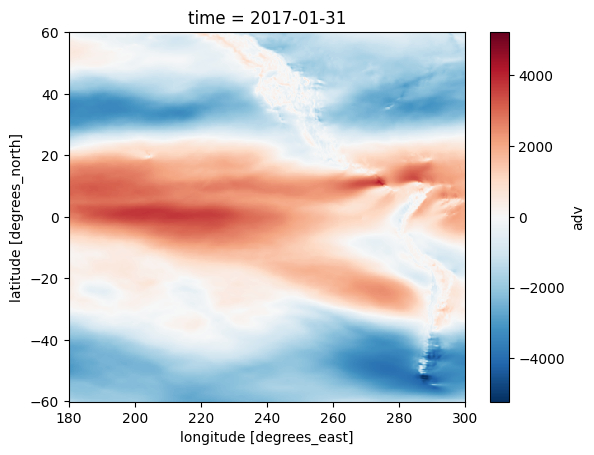

In [10]:
data_850["adv"] = -1*data_850.u*data_850.t
data_850.adv.sel(time="2017-01").plot()

In [11]:
boxes_pacific = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "ocean_pressure": [260, 284, -44, -17], #study max over time and define region
    "chile" : [286, 288, -42, -33]
    #"advección": [280, 285, -37, -30]
}

In [12]:
my_indices = [AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly"),
              AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly"),
              AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["T"], box_limit=boxes_pacific["chile"], rolling_window=1, frequency="monthly"),
              MaxIndex(data_mslp, [1972,2022], variables=["MSL"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)
              # AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=[268,283,-32,-20], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["U"], box_limit=[289,290.5,-34,-30], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["U"], box_limit=[282,289,-38,-34], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["U"], box_limit=[282,288.5,-43,-38], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["U"], box_limit=[282,288.5,-53,-43], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_mslp, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=[282,290.5,-34,-30], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_mslp, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=[291,295,-38,30], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_mslp, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=[282,288.5,-43,-38], rolling_window=1, frequency="monthly"),
              # AnomaliesIndex(data_mslp, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=[280,286,-38,-30], rolling_window=1, frequency="monthly"),
              # MaxIndex(data_mslp, [1972,2022], variables=["MSL"], box_limit=[282,292,-34,-30], anomalies=True, climatology_period=ref_period),
              # MaxIndex(data_mslp, [1972,2022], variables=["MSL"], box_limit=[282,292,-38,-34], anomalies=True, climatology_period=ref_period),
              # MaxIndex(data_mslp, [1972,2022], variables=["MSL"], box_limit=[282,292,-43,-38], anomalies=True, climatology_period=ref_period)
              ]

Lets add custom indices from climate features. Vaguada is MSL config, Advection is 850 data, Winds (Raco and puelche) are U850+MSL data. 

In [13]:
vaguada_index = Index(data_mslp, ["MSL"], [286, 288.5, -33, -28])
vaguada_index.load_index("1f3bbd82","data/my_indices/")
advection_blob_index = Index(data_850, ["ADV"], [268, 283, -32, -20])
advection_blob_index.load_index("e7cf99a9","data/my_indices/")
advection_chile_index = Index(data_850, ["ADV"], [282, 286, -42, -33])
advection_chile_index.load_index("014c3713","data/my_indices/")
bloqueo_north_index = Index(data_850, ["U"], [287.5, 289.5, -37, -33])
bloqueo_north_index.load_index("80ce3764","data/my_indices/")
bloqueo_south_index = Index(data_850, ["U"], [286.5, 288.5, -42, -37])
bloqueo_south_index.load_index("d6188e35","data/my_indices/")


custom_indices = [vaguada_index, advection_blob_index, advection_chile_index, bloqueo_north_index, bloqueo_south_index]
custom_indices_ids = ["1f3bbd82", "aac61eb2","bf935817","80ce3764","d6188e35"]
custom_indices_data = [index.index for index in custom_indices]

In [14]:
my_indices_ids = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in my_indices]

Saved
Saved
Saved
Saved


In [15]:
predictors = Predictor()
extra_indices_names = ["PDO", "ONI", "SAM", "DMI"]
extra_indices = [df_pdo, df_oni, df_sam, df_dmi]


In [16]:
my_indices_data = [index.get_index(var=index.variables[0]) for index in my_indices]

In [17]:
# exp, num = predictors.incorporate_predictor(my_indices, my_indices_ids)
exp, num = predictors.incorporate_predictor(custom_indices_data+my_indices_data+extra_indices, custom_indices_ids+my_indices_ids+extra_indices_names)

## Chile

In [19]:
hwis_chile= pd.read_csv(f"data/local_data/monthly/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y-%m')
hwis_chile.set_index('Date', inplace=True)
region="chile"

In [20]:
exp_label, num_label = predictors.incorporate_label(hwis_chile, num_exp=num)

In [21]:
predictors.experiment_to_parquet(num_label, f"data/climate_features/{region}/", f"data/climate_features/{region}/metadata.csv")

Saved


## California

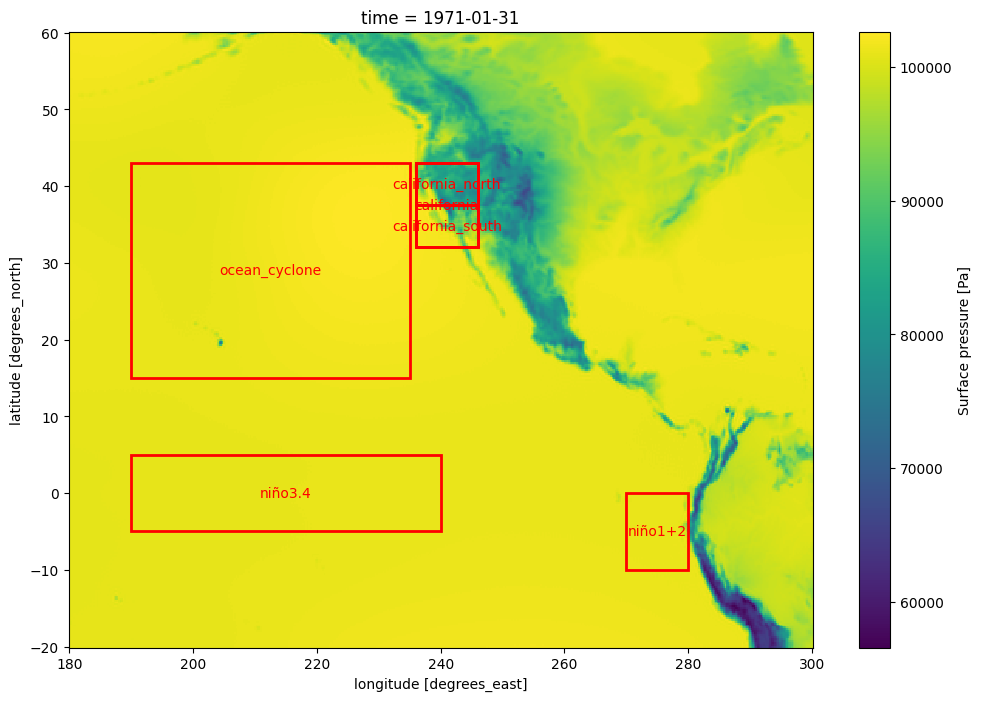

In [37]:
data = xr.load_dataset("data/local_data/7means_east_pacific.nc")

boxes = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "california_north": [236, 246, 37.5, 43],
    "california_south": [236, 246, 32, 37.5],
    "california": [236,246, 32, 43],
    "ocean_cyclone": [190, 235, 15, 43],
}

fig, ax = plt.subplots(figsize=(12, 8))

data.sel(latitude=slice(-20, 60), longitude=slice(130, 300)).sp.isel(time=0).plot(ax=ax)

for box_id, coords in boxes.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [31]:
data = xr.load_dataset("data/local_data/7means_world.nc")

In [32]:
ref_period = [1980,2010]

In [33]:
nino34 = AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes["niño3.4"], rolling_window=1, frequency="monthly")
nino12 = AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes["niño1+2"], rolling_window=1, frequency="monthly")
Indices = [nino34, nino12, 
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SP"], box_limit=boxes["california_north"], rolling_window=1, frequency="monthly"), 
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SP"], box_limit=boxes["california_south"], rolling_window=1, frequency="monthly"),
           MaxIndex(data, [1972,2022], variables=["SP"], box_limit=boxes["ocean_cyclone"]),
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["U10"], box_limit=boxes["california"], rolling_window=1, frequency="monthly")]


In [34]:
ids = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in Indices]

Saved
Saved
Saved
Saved
Saved
Saved


In [37]:
predictors = Predictor()
extra_indices_names = ["PDO", "ONI", "SAM", "DMI"]
extra_indices = [df_pdo, df_oni, df_sam, df_dmi]

my_indices_ids = ids
my_indices = [index.get_index_by_variable(index.variables[0]) for index in Indices]
exp, num = predictors.incorporate_predictor(my_indices+extra_indices, my_indices_ids+extra_indices_names)

In [38]:
hwis_cali= pd.read_csv(f"data/local_data/monthly/HWs_california_NOAA.csv")
hwis_cali["Date"] = pd.to_datetime(hwis_cali["Date"],format='%Y-%m')
hwis_cali.set_index('Date', inplace=True)
region="california"

In [39]:
exp_label2, num_label2 = predictors.incorporate_label(hwis_cali, num_exp=num)

In [45]:
predictors.experiment_to_parquet(num_label2, f"data/climate_features/{region}/", f"data/climate_features/{region}/metadata.csv")

Saved
